### Citation

The training part is from:

François Chollet (2020) The most modern way to implement a WGAN-GP in Keras https://github.com/keras-team/keras-io/blob/master/examples/generative/wgan_gp.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd sample_data
!cp -avr '/content/drive/My Drive/LDCT.zip' '/content/sample_data/'
!unzip LDCT.zip

/content/sample_data
'/content/drive/My Drive/LDCT.zip' -> '/content/sample_data/LDCT.zip'
Archive:  LDCT.zip
replace LDCT/N204/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import shutil
directory_list = []

for item in os.listdir("/content/sample_data//LDCT"):
    directory_list.append(item)
sorted_files = sorted(directory_list)

print(sorted_files)

['.DS_Store', 'C111', 'L125', 'L145', 'N001', 'N139', 'N140', 'N153', 'N160', 'N169', 'N180', 'N181', 'N204']


In [ ]:
sorted_files = sorted_files[1:]

In [ ]:
sorted_files

['C111',
 'L125',
 'L145',
 'N001',
 'N139',
 'N140',
 'N153',
 'N160',
 'N169',
 'N180',
 'N181',
 'N204']

In [ ]:
for folder in sorted_files:
    outer_path = "/content/sample_data//LDCT/"+folder+"/"
    for sub in os.listdir(outer_path):
        inner_path = sub +"/*"
        if sub == ".DS_Store":
            pass
        elif sub == ".ipynb_checkpoints":
            pass
        else:
            os.system("mv  -v "+outer_path+inner_path+" "+outer_path)
            os.system("mv "+outer_path+"*Full* "+outer_path+"full_dose")
            os.system("mv "+outer_path+"*Low* "+outer_path+"low_dose")
            shutil.rmtree(os.path.join(outer_path,sub))

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 2.7MB/s 


### Start from this line
***

In [ ]:
import pydicom as dicom
import os

def load_path(path):
    directories_low = []
    directories_full = []
    directory_list = os.listdir(path)
    directory_list = sorted(directory_list)
    for i in directory_list:
        if os.path.isdir(os.path.join(path,i)):
            path_image = os.path.join(path,i)
            path_full = os.path.join(path_image,"full_dose")
            path_low = os.path.join(path_image,"low_dose")
            directories_full.append(path_full)
            directories_low.append(path_low)
    return directories_full, directories_low

In [ ]:
def load_data_from_dirs(dirs):
    files = []
    file_names = []
    for d in dirs:
        for f in os.listdir(d): 
            if f.endswith('dcm'):
                file_name = os.path.join(d,f)
                ds = dicom.dcmread(file_name)
                image = ds.pixel_array
                files.append(image)
                #file_names.append(os.path.join(d,f))     
    return files

In [ ]:
directories_full, directories_low = load_path("/content/sample_data//LDCT")

In [ ]:
directories_low

['/content/sample_data//LDCT/C111/low_dose',
 '/content/sample_data//LDCT/L125/low_dose',
 '/content/sample_data//LDCT/L145/low_dose',
 '/content/sample_data//LDCT/N001/low_dose',
 '/content/sample_data//LDCT/N139/low_dose',
 '/content/sample_data//LDCT/N140/low_dose',
 '/content/sample_data//LDCT/N153/low_dose',
 '/content/sample_data//LDCT/N160/low_dose',
 '/content/sample_data//LDCT/N169/low_dose',
 '/content/sample_data//LDCT/N180/low_dose',
 '/content/sample_data//LDCT/N181/low_dose',
 '/content/sample_data//LDCT/N204/low_dose']

In [ ]:
directories_full

['/content/sample_data//LDCT/C111/full_dose',
 '/content/sample_data//LDCT/L125/full_dose',
 '/content/sample_data//LDCT/L145/full_dose',
 '/content/sample_data//LDCT/N001/full_dose',
 '/content/sample_data//LDCT/N139/full_dose',
 '/content/sample_data//LDCT/N140/full_dose',
 '/content/sample_data//LDCT/N153/full_dose',
 '/content/sample_data//LDCT/N160/full_dose',
 '/content/sample_data//LDCT/N169/full_dose',
 '/content/sample_data//LDCT/N180/full_dose',
 '/content/sample_data//LDCT/N181/full_dose',
 '/content/sample_data//LDCT/N204/full_dose']

In [ ]:
len(directories_full)

12

In [ ]:
fr_filename_train = load_data_from_dirs(directories_full)
lr_filename_train = load_data_from_dirs(directories_low)

In [ ]:
len(fr_filename_train)

900

In [ ]:
import numpy as np
lr_train = np.array(lr_filename_train)
fr_train = np.array(fr_filename_train)

In [ ]:
lr_train = lr_train.reshape((lr_train.shape[0], lr_train.shape[1],lr_train.shape[2], 1))
fr_train = fr_train.reshape((fr_train.shape[0], fr_train.shape[1],fr_train.shape[2], 1))

In [ ]:
lr_train.shape

(900, 512, 512, 1)

In [ ]:
"""
def calculate_psnr(img1, img2, max_value=255):
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 0
    return 20 * np.log10(max_value / (np.sqrt(mse)))

import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

PSNR1 =[]
SSIM1 = []

for low_img,high_img in zip(lr_train,fr_train):
  psnr1= calculate_psnr(low_img,high_img)
  ssim1 = calculate_ssim(low_img,high_img)
  PSNR1.append(psnr1)
  SSIM1.append(ssim1)
"""

"\ndef calculate_psnr(img1, img2, max_value=255):\n    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)\n    if mse == 0:\n        return 0\n    return 20 * np.log10(max_value / (np.sqrt(mse)))\n\nimport math\nimport numpy as np\nimport cv2\n\ndef ssim(img1, img2):\n    C1 = (0.01 * 255)**2\n    C2 = (0.03 * 255)**2\n\n    img1 = img1.astype(np.float64)\n    img2 = img2.astype(np.float64)\n    kernel = cv2.getGaussianKernel(11, 1.5)\n    window = np.outer(kernel, kernel.transpose())\n\n    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid\n    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]\n    mu1_sq = mu1**2\n    mu2_sq = mu2**2\n    mu1_mu2 = mu1 * mu2\n    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq\n    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq\n    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2\n\n    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu

In [ ]:
import tensorflow as tf

def crop_image(example):
    img = example['hr']
    img1 = example['lr']
    hr_patch = tf.image.central_crop(img,0.5)
    lr_patch = tf.image.central_crop(img1,0.5)
    hr_patch = tf.cast(hr_patch, tf.float32) / (255. / 2.)
    lr_patch = tf.cast(lr_patch, tf.float32) / (255. / 2.)
    #lr_patch = tf.image.resize(hr_patch, size=[96, 96])
    return lr_patch, hr_patch

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices({'lr': lr_train,'hr': fr_train})

In [ ]:
train_data

<TensorSliceDataset shapes: {lr: (512, 512, 1), hr: (512, 512, 1)}, types: {lr: tf.uint16, hr: tf.uint16}>

In [ ]:
train_dataset = train_data.map(crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

In [ ]:
train_dataset = train_dataset.batch(9).repeat()

In [ ]:
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [ ]:

PSNR = []
SSIM = []
count_num = 0
for img1, img2 in train_dataset:
  psnr_test = tf.image.psnr(img1,img2,max_val=2.0)
  ssim_test = tf.image.ssim(img1,img2,max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
  PSNR.append(psnr_test)
  SSIM.append(ssim_test)
  count_num += 1
PSNR = tf.convert_to_tensor(PSNR)
PSNR_ave = tf.math.reduce_mean(PSNR[PSNR<1000])
psnr_array = PSNR_ave.numpy()
print(psnr_array[psnr_array < 1000])
SSIM = tf.convert_to_tensor(SSIM)
SSIM_ave = tf.math.reduce_mean(SSIM)
print(SSIM_ave.numpy())


KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from numpy.random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt

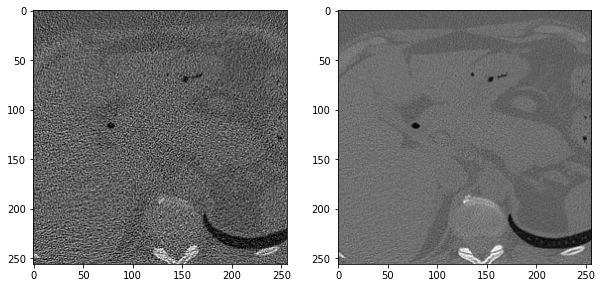

In [ ]:
cropped_img_iter = iter(train_dataset)
val_cropped_img = next(cropped_img_iter)
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(tf.squeeze(val_cropped_img[0][0]),cmap='gray')
axes[1].imshow(tf.squeeze(val_cropped_img[1][0]),cmap='gray')

### Original Generator


In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 1)) # Model to 2x the image
x = inputs
x = tf.keras.layers.Conv2D(64, 9, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
c1 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])
c2 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c2, x])
c3 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c3, x])
c4 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c4, x])
c5 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c5, x])
c6 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
#x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
#x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(1, 9, padding='same')(x)
output = x
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 256, 256, 64) 4194304     conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       p_re_lu[0][0]                    
_______________________________________________________________________________________

***

### Original Dis


In [ ]:
inputs_d = tf.keras.Input(shape=(256, 256, 1)) # Discriminator Model
x_d = inputs_d
x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(128, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Flatten()(x_d)
x_d = tf.keras.layers.Dense(1024)(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)
x_d = tf.keras.layers.Dense(1, activation='sigmoid')(x_d)
output_d = x_d
model_d = tf.keras.Model(inputs_d, output_d)
model_d.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)      

***

In [ ]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator

  def compile(self, 
              d_optimizer, 
              g_optimizer, 
              loss_fn, 
              recon_loss_fn, 
              loss_weights=[1,1,1]):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.recon_loss_fn = recon_loss_fn
    self.loss_weights = loss_weights

  def train_step(self, data):
    input_images, real_images = data 
    batch_size = tf.shape(real_images)[0] 
    #print(batch_size)
    generated_images = self.generator(input_images)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat([tf.ones((batch_size, 1)),
                        -tf.ones((batch_size, 1))], axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    #print(tf.shape(combined_images))
    with tf.GradientTape() as tape:
      noise_concat = tf.concat([tf.random.normal(shape=tf.shape(generated_images), mean=0.0, stddev=0.1, dtype=tf.float32),
                                tf.zeros(shape=tf.shape(real_images))], axis=0)
      noisy_image =combined_images + noise_concat
      predictions = self.discriminator(noisy_image)
      d_loss = self.loss_fn(labels, predictions)
      d_loss = d_loss*self.loss_weights[0]
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    with tf.GradientTape() as tape:
      generated_images = self.generator(input_images)
      predictions = self.discriminator(generated_images)
      g_loss = self.loss_fn(-tf.ones((batch_size, 1)), predictions)
      recon_loss = self.recon_loss_fn(real_images, generated_images)
      loss = g_loss*self.loss_weights[1] + recon_loss*self.loss_weights[2]
    grads = tape.gradient(loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    psnr = tf.image.psnr(generated_images, real_images, max_val=2.0)
    ssim = tf.image.ssim(generated_images, real_images, max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    return { 'd_loss': d_loss, 'g_loss': g_loss, 'recon_loss': recon_loss, 'PSNR':psnr, 'SSIM':ssim }


gan_model = GAN(model_d, model)
gan_model.compile(tf.keras.optimizers.Adam(lr=0.0001), 
                  tf.keras.optimizers.Adam(lr=0.0001), 
                  discriminator_loss, 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.mean_squared_error(y,x)),
                  loss_weights=[1,10, 1])

In [ ]:
gan_model.fit(train_dataset, steps_per_epoch=50, epochs=50)

Epoch 1/50
50/50 [==============================] - 53s 1s/step - d_loss: -0.0250 - g_loss: 1.0000 - recon_loss: 0.1977 - PSNR: 14.8561 - SSIM: 0.5245
Epoch 2/50
50/50 [==============================] - 53s 1s/step - d_loss: -0.0262 - g_loss: 1.0000 - recon_loss: 0.0206 - PSNR: 23.9970 - SSIM: 0.8272
Epoch 3/50
50/50 [==============================] - 53s 1s/step - d_loss: -0.0248 - g_loss: 1.0000 - recon_loss: 0.1927 - PSNR: 14.9628 - SSIM: 0.5260
Epoch 4/50
50/50 [==============================] - 53s 1s/step - d_loss: -0.0250 - g_loss: 1.0000 - recon_loss: 0.0197 - PSNR: 24.7622 - SSIM: 0.8268
Epoch 5/50
50/50 [==============================] - 53s 1s/step - d_loss: -0.0248 - g_loss: 1.0000 - recon_loss: 0.2015 - PSNR: 14.7507 - SSIM: 0.5265
Epoch 6/50
50/50 [==============================] - 53s 1s/step - d_loss: -0.0250 - g_loss: 1.0000 - recon_loss: 0.0122 - PSNR: 26.2400 - SSIM: 0.8285
Epoch 7/50
50/50 [==============================] - 53s 1s/step - d_loss: -0.0253 - g_loss: 1.

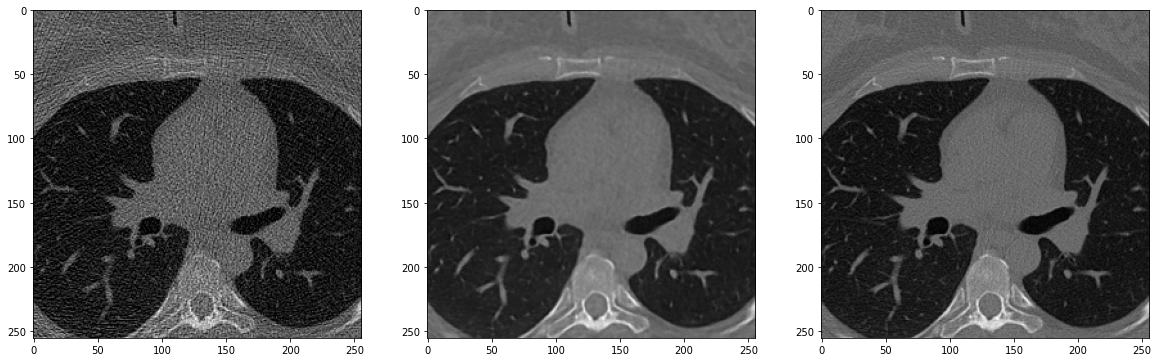

In [ ]:
fakes = model.predict(val_cropped_img[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img[0][1].numpy())
us = np.squeeze(fakes[1])
ori = np.squeeze(val_cropped_img[1][1])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')

## Test Part

In [ ]:
%cd sample_data
!cp -avr '/content/drive/My Drive/LDCT-test.zip' '/content/sample_data/'
!unzip LDCT-test.zip

[Errno 2] No such file or directory: 'sample_data'
/content/sample_data
'/content/drive/My Drive/LDCT-test.zip' -> '/content/sample_data/LDCT-test.zip'
Archive:  LDCT-test.zip
   creating: LDCT-test/
  inflating: LDCT-test/.DS_Store     
   creating: __MACOSX/LDCT-test/
  inflating: __MACOSX/LDCT-test/._.DS_Store  
   creating: LDCT-test/L058/
  inflating: LDCT-test/L058/.DS_Store  
   creating: __MACOSX/LDCT-test/L058/
  inflating: __MACOSX/LDCT-test/L058/._.DS_Store  
   creating: LDCT-test/L058/08-27-2018-32654/
  inflating: LDCT-test/L058/08-27-2018-32654/.DS_Store  
   creating: __MACOSX/LDCT-test/L058/08-27-2018-32654/
  inflating: __MACOSX/LDCT-test/L058/08-27-2018-32654/._.DS_Store  
   creating: LDCT-test/L058/08-27-2018-32654/1.000000-Low Dose Images-39820/
  inflating: LDCT-test/L058/08-27-2018-32654/1.000000-Low Dose Images-39820/1-013.dcm  
   creating: __MACOSX/LDCT-test/L058/08-27-2018-32654/1.000000-Low Dose Images-39820/
  inflating: __MACOSX/LDCT-test/L058/08-27-2018-

In [ ]:
directory_list = []

for item in os.listdir("/content/sample_data/LDCT-test"):
    directory_list.append(item)
sorted_files = sorted(directory_list)

print(sorted_files)


sorted_files = sorted_files[1:]
print(sorted_files)

['.DS_Store', 'C052', 'L058', 'N156']
['C052', 'L058', 'N156']


In [ ]:
import os
import shutil

In [ ]:
#shutil.rmtree('/content/sample_data/Abdmen_test')
#os.remove('/content/sample_data/Abdmen_test.zip')

In [ ]:


for folder in sorted_files:
    outer_path = "/content/sample_data/LDCT-test/"+folder+"/"
    for sub in os.listdir(outer_path):
        inner_path = sub +"/*"
        if sub == ".DS_Store":
            pass
        elif sub == ".ipynb_checkpoints":
            pass
        else:
            os.system("mv  -v "+outer_path+inner_path+" "+outer_path)
            os.system("mv "+outer_path+"*Full* "+outer_path+"full_dose")
            os.system("mv "+outer_path+"*Low* "+outer_path+"low_dose")
            shutil.rmtree(os.path.join(outer_path,sub))

In [ ]:
directories_full, directories_low = load_path("/content/sample_data/LDCT-test")
print(directories_low)
print(directories_full)

['/content/sample_data/LDCT-test/C052/low_dose', '/content/sample_data/LDCT-test/L058/low_dose', '/content/sample_data/LDCT-test/N156/low_dose']
['/content/sample_data/LDCT-test/C052/full_dose', '/content/sample_data/LDCT-test/L058/full_dose', '/content/sample_data/LDCT-test/N156/full_dose']


In [ ]:
fr_filename_test = load_data_from_dirs(directories_full)
lr_filename_test = load_data_from_dirs(directories_low)
len(fr_filename_test)
fr_test = np.array(fr_filename_test)
lr_test= np.array(lr_filename_test)
lr_test = lr_test.reshape((lr_test.shape[0], lr_test.shape[1],lr_test.shape[2], 1))
fr_test = fr_test.reshape((fr_test.shape[0], fr_test.shape[1],fr_test.shape[2], 1))
print(lr_test.shape)

(100, 512, 512, 1)


In [ ]:
test_data = tf.data.Dataset.from_tensor_slices({'lr': lr_test,'hr': fr_test})
test_data = test_data.map(crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_data = test_data.batch(10)

In [ ]:
PSNR = []
SSIM = []
count_num = 0
for img1, img2 in test_data:
  psnr_test = tf.image.psnr(img1,img2,max_val=2.0)
  ssim_test = tf.image.ssim(img1,img2,max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
  PSNR.append(psnr_test)
  SSIM.append(ssim_test)
  count_num += 1
PSNR = tf.convert_to_tensor(PSNR)
PSNR_ave = tf.math.reduce_mean(PSNR[PSNR<1000])
psnr_array = PSNR_ave.numpy()
print(psnr_array[psnr_array < 1000])
SSIM = tf.convert_to_tensor(SSIM)
SSIM_ave = tf.math.reduce_mean(SSIM)
print(SSIM_ave.numpy())

[14.967391]
0.5562585


In [ ]:
PSNR = []
SSIM = []

In [ ]:
for img1, img2 in test_data:
  predicted_img = model.predict(img1)
  psnr_test = tf.image.psnr(predicted_img,img2,max_val=2.0)
  ssim_test = tf.image.ssim(predicted_img,img2,max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
  PSNR.append(psnr_test)
  SSIM.append(ssim_test)

In [ ]:
PSNR = tf.convert_to_tensor(PSNR)
PSNR_ave = tf.math.reduce_mean(PSNR)
print(PSNR_ave.numpy())
SSIM = tf.convert_to_tensor(SSIM)
SSIM_ave = tf.math.reduce_mean(SSIM)
print(SSIM_ave.numpy())

14.018671
0.6209147


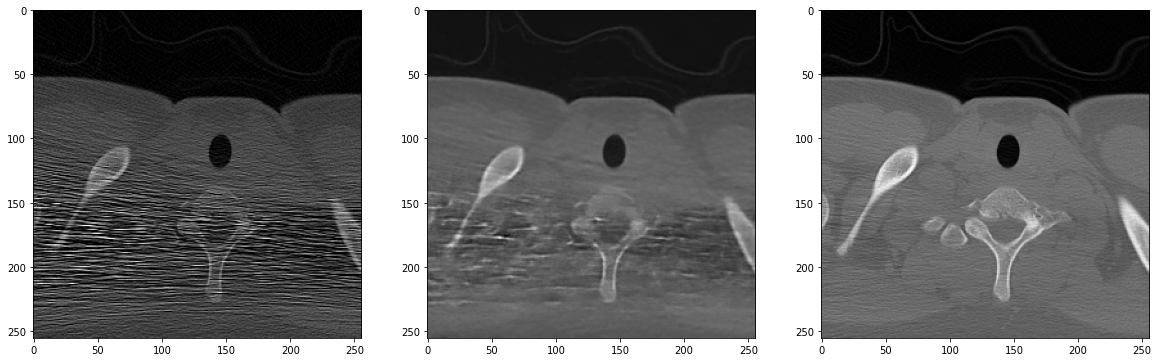

In [ ]:
cropped_img_iter_test = iter(test_data)
val_cropped_img_test  = next(cropped_img_iter_test )
fakes_test  = model.predict(val_cropped_img_test[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img_test[0][2].numpy())
us = np.squeeze(fakes_test[2])
ori = np.squeeze(val_cropped_img_test[1][2])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')
plt.savefig('100epoch_wgan_0.0001wei.png')

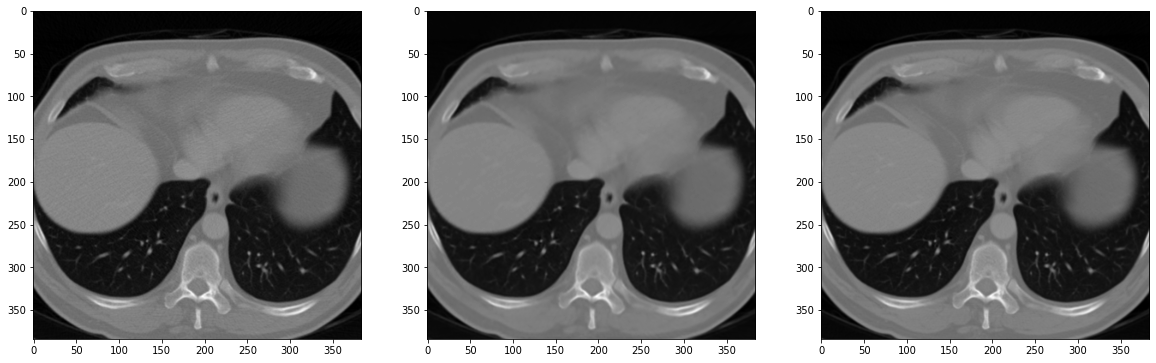

In [ ]:
cropped_img_iter_test = iter(test_data)
val_cropped_img_test  = next(cropped_img_iter_test )
fakes_test  = model.predict(val_cropped_img_test[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img_test[0][0].numpy())
us = np.squeeze(fakes_test[0])
ori = np.squeeze(val_cropped_img_test[1][0])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')
plt.savefig('100epoch_wgan_0.0001wei.png')

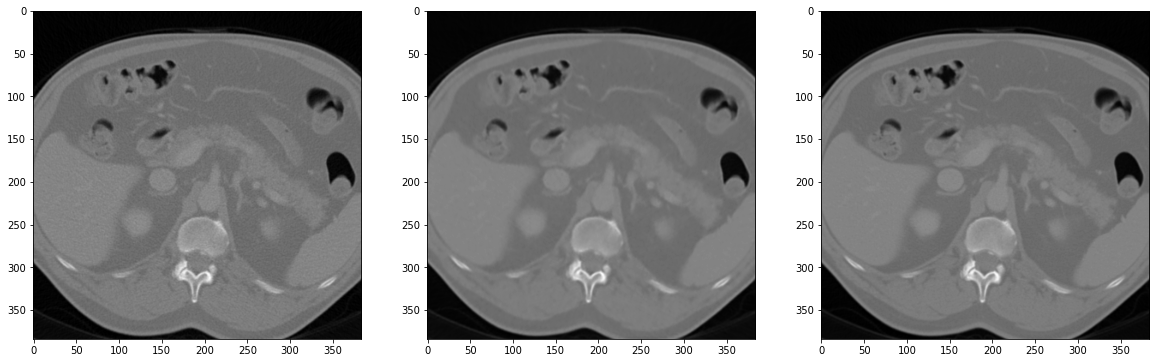

In [ ]:
cropped_img_iter_test = iter(test_data)
val_cropped_img_test  = next(cropped_img_iter_test )
fakes_test  = model.predict(val_cropped_img_test[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img_test[0][3].numpy())
us = np.squeeze(fakes_test[3])
ori = np.squeeze(val_cropped_img_test[1][3])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')
plt.savefig('100epoch_wgan_0.0001wei.png')